In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.graphgym import train
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import networkx as nx
import numpy as np
from torch_geometric.data import DataLoader
import os
import pickle

In [2]:
os.chdir('..')

Преобразование графа в нужный формат

In [3]:
def nx_to_pyg_data(G, node_characteristics, label):
    node_mapping = {node: i for i, node in enumerate(G.nodes())}
    
    # Преобразуем рёбра с учётом отображения узлов
    edge_index = torch.tensor(
        [(node_mapping[src], node_mapping[dst]) for src, dst in G.edges()],
        dtype=torch.long
    ).t().contiguous()
    
    # Преобразуем признаки узлов в тензор
    x = torch.tensor(node_characteristics, dtype=torch.float)
    
    # Преобразуем метку в тензор
    y = torch.tensor([label], dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, y=y)

Графы для обучения

In [4]:
small_components_all = {}
small_components_families_all = {}
largest_component_all = {}
largest_component_families_all = {}
G_all = {}
node2name_dict_all = {}
name2seq_all = {}
node_freq_dict_all = {}
node_family_dict_all = {}

In [5]:
# Функция для загрузки данных из файла
def load_data_from_file(filename):
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

def process_components(name):
    small_components_filename = os.path.join('data', f'data_{name}.pkl')
    if os.path.exists(small_components_filename):
        data = load_data_from_file(small_components_filename)
        if data:
            G_all[name] = data['graph']
            node_freq_dict_all[name] = data['node_freq_dict']
            node_family_dict_all[name] = data['node_family_dict']
        return True
    return False


# Процесс получения меток для маленьких компонент
def process_small_components(name):
    small_components_families_filename = os.path.join('data', f'small_components_families_{name}.pkl')
    if os.path.exists(small_components_families_filename):
        data = load_data_from_file(small_components_families_filename)
        if data:
            small_components_families_all[name] = data['families']
            small_components_all[name] = data['components']
        return True
    return False

# Процесс получения кластеров и меток для большой компоненты
def process_largest_component(name):
    largest_component_filename = os.path.join('data', f'largest_component_clusters_{name}.pkl')
    if os.path.exists(largest_component_filename):
        data = load_data_from_file(largest_component_filename)
        if data:
            largest_component = data['clusters']
            largest_component_families = data['families']
            
            largest_component_all[name] = largest_component
            largest_component_families_all[name] = largest_component_families
        return True
    return False

def process_dicts(name):
    dicts_filename = os.path.join('data', f'dicts_{name}.pkl')
    if os.path.exists(dicts_filename):
        data = load_data_from_file(dicts_filename)
        if data:
            node2name_dict_all[name] = data['node2name_dict']
            name2seq_all[name] = data['name2seq']

        return True
    return False
    

In [6]:
name = 'arab'
if not process_small_components(name):
    print(f"File for {name} (small components families) not found.")

if not process_largest_component(name):
    print(f"File for {name} (largest component) not found.")
    
if not process_components(name):
    print(f"File for {name} (all components) not found.")

if not process_dicts(name):
    print(f"File for {name} (all dicts) not found.")

In [7]:
components = list(small_components_all[name]) + list(largest_component_all[name])
families = list(small_components_families_all[name]) + list(largest_component_families_all[name])

In [8]:
from funcs.parsing import generate_random_kmers
from funcs.embeddings import node_characteristics
random_kmers = generate_random_kmers(4, 100)

embeddings = []

for component_nodes in components:
    G_sub = G_all[name].subgraph(component_nodes)
    
    node_embeddings = []
    for node in component_nodes:
        embedding = node_characteristics(node, G_sub, node_freq_dict_all[name], random_kmers, node2name_dict_all[name], name2seq_all[name])
        node_embeddings.append(embedding)
    
    embeddings.append(node_embeddings)

/Users/nad/miniconda3/envs/sna/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
G = G_all[name]

In [10]:
families_to_filter = ['LTR', 'Helitron', 'DNA/MuDR', 'LINE']
families_dict = {type_str: idx for idx, type_str in enumerate(families_to_filter)}

In [11]:
train_data = []

for i in range(len(components)):
    if families[i] not in families_to_filter:
        continue
    component_nodes = components[i]
    G_sub = G.subgraph(component_nodes)

    # G_sub_new = G_new.subgraph([vertex_map[x] for x in component_nodes])

    target = [0] * len(families_to_filter)
    target[families_dict[families[i]]] = 1

    graph_embedding = nx_to_pyg_data(G_sub, embeddings[i], target)
    train_data.append(graph_embedding)

# Обучение

In [12]:
from models.gnn import GNN, ComplexGAT

In [13]:
from torch_geometric.loader import DataLoader
loader = DataLoader(train_data, batch_size=1, shuffle=True)

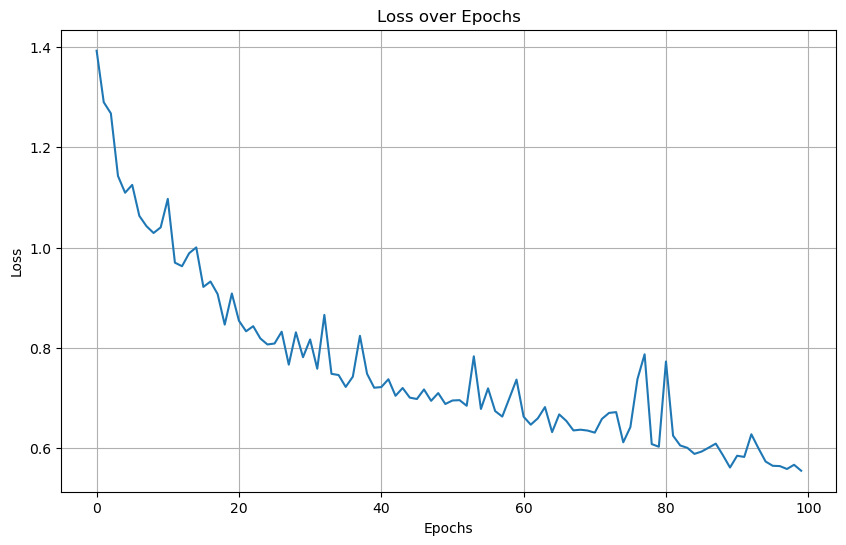

In [14]:
import torch
import matplotlib.pyplot as plt

model = GNN(in_channels=103, hidden_channels=16, out_channels=4, heads=2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# для хранения значений лосса по эпохам
losses = []

epochs = 100

# Обучающий цикл
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index, batch.batch)

        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    losses.append(avg_loss)  # значение лосса

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid(True)
plt.show()

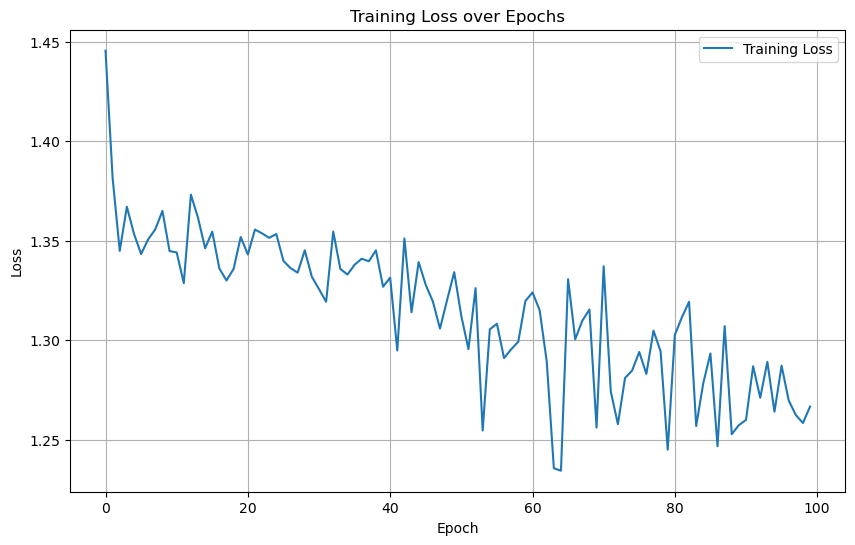

In [15]:
import torch
import matplotlib.pyplot as plt

# Параметры модели
in_channels = 103    # Количество признаков на узел
hidden_channels = 16
out_channels = 4     # Количество классов
num_layers = 3
add_bn = True
dropout = 0.5
heads = 2

# Инициализация модели
model2 = ComplexGAT(in_channels, hidden_channels, out_channels, num_layers, add_bn, dropout, heads)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)

batch_size = 16
loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Список для хранения лосса
losses = []

# Обучающий цикл
model2.train()
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        
        out = model2(batch.x, batch.edge_index, batch.batch)
        
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    losses.append(avg_loss)
    # print(f"Epoch {epoch}, Loss: {avg_loss}")

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
model_dir = 'models_files'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Сохранение модели
model_filename = os.path.join(model_dir, 'gnn.pkl')
if not os.path.exists(model_filename):
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)

print(f"Успешно сохранена в {model_filename}")


Успешно сохранена в models_files/gnn.pkl


In [17]:
filename = os.path.join('data', 'kmers.pkl')
if not os.path.exists(filename):
    with open(filename, 'wb') as f:
        pickle.dump(random_kmers, f)

Epoch 1/100, Loss: 1.3679
Epoch 10/100, Loss: 1.0226
Epoch 20/100, Loss: 0.8520
Epoch 30/100, Loss: 0.8126
Epoch 40/100, Loss: 0.6288
Epoch 50/100, Loss: 0.6216
Epoch 60/100, Loss: 0.5494
Epoch 70/100, Loss: 0.4954
Epoch 80/100, Loss: 0.4843
Epoch 90/100, Loss: 0.5202
Epoch 100/100, Loss: 0.3727


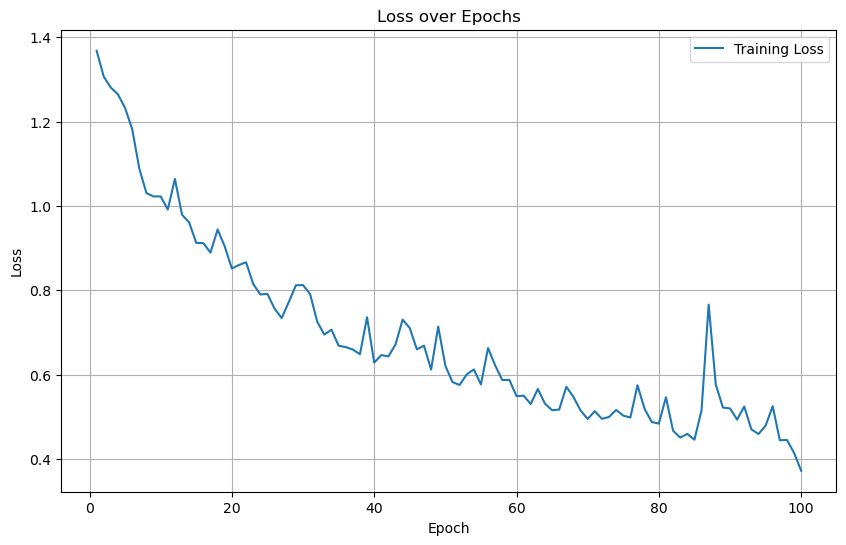

In [29]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_dataset, test_dataset = train_test_split(
    train_data, 
    test_size=0.2, 
    random_state=42, 
    stratify=[np.argmax(data.y).item() for data in train_data]
)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = GNN(in_channels=103, hidden_channels=16, out_channels=4, heads=2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []

epochs = 100

model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index, batch.batch)

        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)  # Loss value

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Accuracy: 0.6880
Precision (Weighted): 0.6904
Recall (Weighted): 0.6880
F1-Score (Weighted): 0.6846

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        42
           1       0.69      0.74      0.71        34
           2       0.63      0.46      0.53        26
           3       0.59      0.74      0.65        23

    accuracy                           0.69       125
   macro avg       0.67      0.67      0.67       125
weighted avg       0.69      0.69      0.68       125

Confusion Matrix:
[[32  4  2  4]
 [ 3 25  2  4]
 [ 4  6 12  4]
 [ 2  1  3 17]]
Confusion Matrix


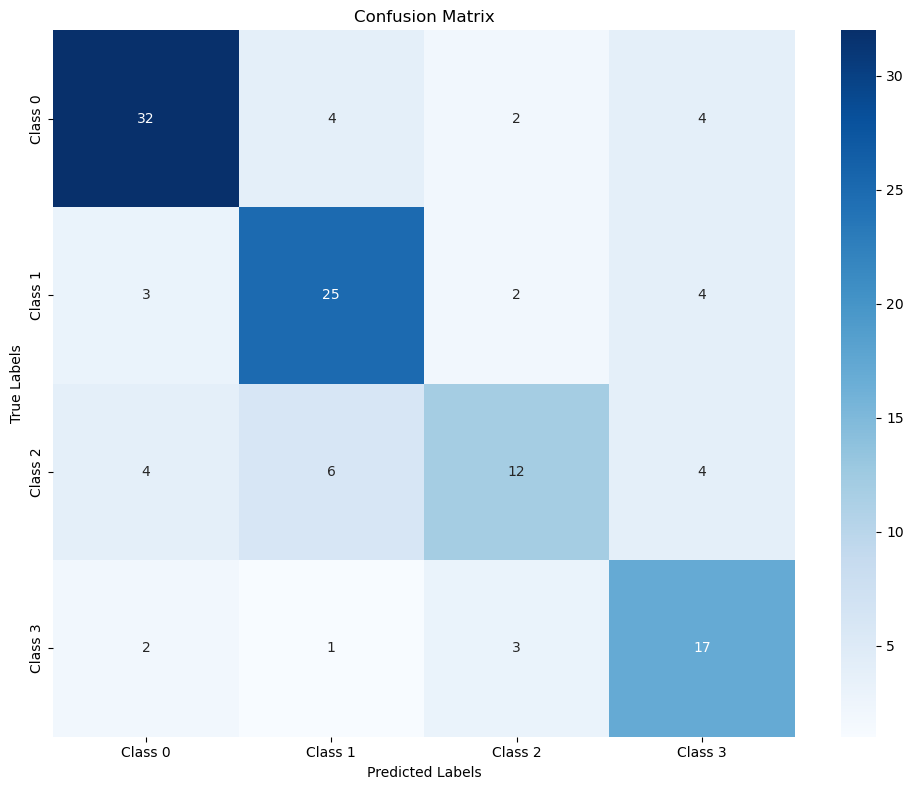

Normalized Confusion Matrix


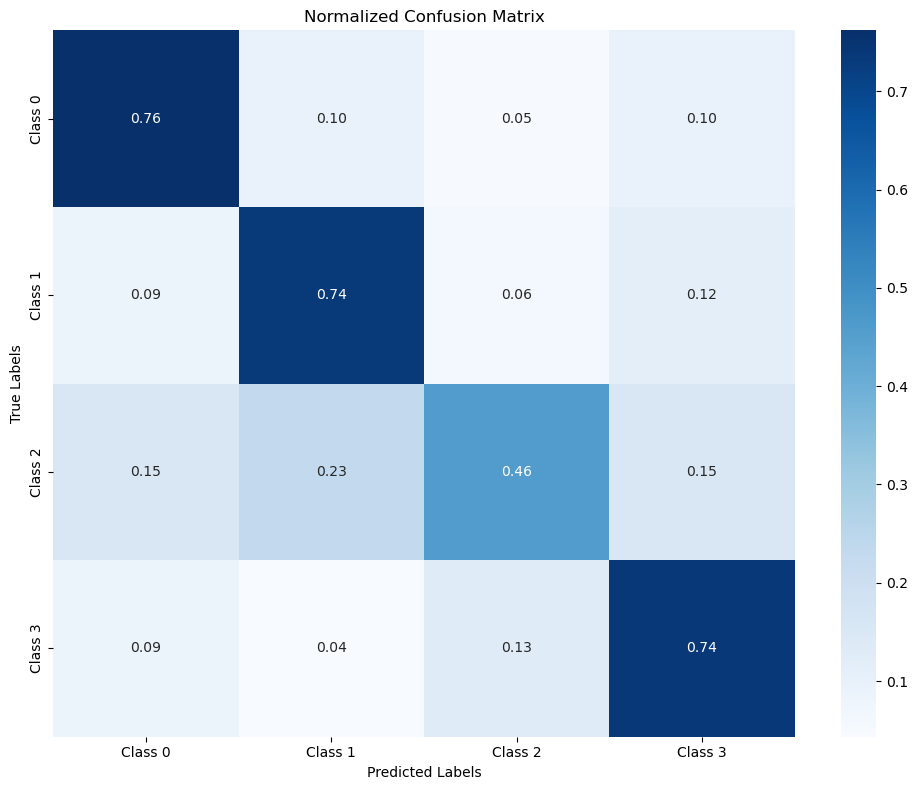

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1).cpu().numpy()

            if len(batch.y.shape) > 1 and batch.y.shape[1] > 1:
                labels = batch.y.argmax(dim=1).cpu().numpy()
            else:
                labels = batch.y.cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    return np.array(all_preds), np.array(all_labels)

test_preds, test_labels = evaluate(model, test_loader, device)

accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, support = precision_recall_fscore_support(
    test_labels, test_preds, average='weighted', zero_division=0
)
conf_matrix = confusion_matrix(test_labels, test_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (Weighted): {precision:.4f}')
print(f'Recall (Weighted): {recall:.4f}')
print(f'F1-Score (Weighted): {f1:.4f}')
print('\nClassification Report:')
print(classification_report(test_labels, test_preds, zero_division=0))

print('Confusion Matrix:')
print(conf_matrix)

def plot_confusion_matrix(conf_matrix, class_names, normalize=False, title='Confusion Matrix'):
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        print("Normalized Confusion Matrix")
    else:
        fmt = 'd'
        print("Confusion Matrix")

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.tight_layout()
    plt.show()

num_classes = conf_matrix.shape[0]
class_names = [f'Class {i}' for i in range(num_classes)]

plot_confusion_matrix(conf_matrix, class_names, normalize=False, title='Confusion Matrix')

plot_confusion_matrix(conf_matrix, class_names, normalize=True, title='Normalized Confusion Matrix')